# 📌 1. Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# HITO 1

In [89]:
metadata = pd.read_csv("HAM10000_metadata.csv")

In [94]:
# Verificar valores faltantes en el dataset
print("Valores faltantes por columna:")
print(metadata.isnull().sum())

Valores faltantes por columna:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [91]:
# Seleccionar columnas relevantes
df_tab = metadata[['age', 'sex', 'localization', 'dx']].dropna()

# Codificar variables categóricas
le_sex = LabelEncoder()
le_loc = LabelEncoder()
le_dx = LabelEncoder()

In [92]:
df_tab['age'] = df_tab['age'].fillna(df_tab['age'].mean())

In [95]:
df_tab['sex'] = le_sex.fit_transform(df_tab['sex'].fillna('unknown'))
df_tab['localization'] = le_loc.fit_transform(df_tab['localization'].fillna('unknown'))
df_tab['dx'] = le_dx.fit_transform(df_tab['dx'])

In [96]:
X_tab = df_tab[['age', 'sex', 'localization']].values
y = df_tab['dx'].values

In [97]:
# Normalizar
scaler = StandardScaler()
X_tab_scaled = scaler.fit_transform(X_tab)

In [100]:
# One-hot para las etiquetas
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(y)

In [102]:
# División estratificada
train_idx, temp_idx, y_train_raw, y_temp_raw = train_test_split(
    np.arange(len(X_tab_scaled)), y_cat, test_size=0.3, random_state=42, stratify=y_cat
)
val_idx, test_idx, y_val_raw, y_test_raw = train_test_split(
    temp_idx, y_cat[temp_idx], test_size=0.5, random_state=42, stratify=y_cat[temp_idx]
)

# Extraer datos
X_train = X_tab_scaled[train_idx]
X_val   = X_tab_scaled[val_idx]
X_test  = X_tab_scaled[test_idx]

y_train = y_cat[train_idx]
y_val   = y_cat[val_idx]
y_test  = y_cat[test_idx]


In [108]:
num_classes = y_train.shape[1]  # ← 7 si es one-hot
print(f"num_classes: {num_classes}")

num_classes: 7


In [109]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def objective(params):
    learning_rate = params['learning_rate']
    batch_size = int(params['batch_size'])
    units1 = int(params['units1'])
    units2 = int(params['units2'])

    model = Sequential([
        Dense(units1, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(units2, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        epochs=10,  # puedes aumentar para producción
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=0
    )

    val_acc = history.history['val_accuracy'][-1]

    return {'loss': -val_acc, 'status': STATUS_OK}

# Definir espacio de búsqueda
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'units1': hp.choice('units1', [32, 64, 128]),
    'units2': hp.choice('units2', [16, 32, 64]),
}

# Ejecutar la búsqueda
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

print("\nMejor combinación encontrada:")
print(best)


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████| 20/20 [01:28<00:00,  4.40s/trial, best loss: -0.6887550354003906]

Mejor combinación encontrada:
{'batch_size': np.int64(1), 'learning_rate': np.float64(0.008633063248006917), 'units1': np.int64(0), 'units2': np.int64(1)}


In [111]:
batch_sizes = [16, 32, 64]
units1_list = [32, 64, 128]
units2_list = [16, 32, 64]

print("\nMejor combinación encontrada (decodificada):")
print(f"batch_size: {batch_sizes[best['batch_size']]}")
print(f"learning_rate: {best['learning_rate']:.6f}")
print(f"units1: {units1_list[best['units1']]}")
print(f"units2: {units2_list[best['units2']]}")



Mejor combinación encontrada (decodificada):
batch_size: 32
learning_rate: 0.008633
units1: 32
units2: 32


In [113]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convertir one-hot a etiquetas enteras
y_train_labels = np.argmax(y_train, axis=1)

# Calcular pesos de clase
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Crear diccionario
class_weights_dict = dict(enumerate(class_weights))

print("\nPesos de clase calculados:")
print(class_weights_dict)



Pesos de clase calculados:
{0: np.float64(4.348097317529632), 1: np.float64(2.765873015873016), 2: np.float64(1.3067116610423697), 3: np.float64(12.446428571428571), 4: np.float64(1.279838413514506), 5: np.float64(0.21358092786664215), 6: np.float64(10.057720057720058)}


In [242]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Arquitectura simple para datos tabulares
input_tab = Input(shape=(X_train.shape[1],))
x = Dense(units1_list[best["units1"]], activation="relu")(input_tab)
x = Dropout(0.3)(x)
x = Dense(units2_list[best["units2"]], activation="relu")(x)
output = Dense(num_classes, activation="softmax")(x)

model_tab = Model(inputs=input_tab, outputs=output)
model_tab.compile(
    optimizer=Adam(learning_rate=best["learning_rate"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [243]:
model_tab.summary()

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_88 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,415 (5.53 KB)

 Trainable params: 1,415 (5.53 KB)

 Non-trainable params: 0 (0.00 B)

In [244]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Entrenamiento con pesos de clase
history_tab_w = model_tab.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=batch_sizes[best["batch_size"]],
    shuffle=True,
    class_weight=class_weights_dict,
    # callbacks=[early_stop]
)

Epoch 1/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2499 - loss: 1.8911 - val_accuracy: 0.3327 - val_loss: 1.6314
Epoch 2/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2267 - loss: 1.8165 - val_accuracy: 0.3621 - val_loss: 1.6653
Epoch 3/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2950 - loss: 1.7764 - val_accuracy: 0.1807 - val_loss: 1.6978
Epoch 4/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1773 - loss: 1.8014 - val_accuracy: 0.2262 - val_loss: 1.6685
Epoch 5/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2457 - loss: 1.7666 - val_accuracy: 0.1352 - val_loss: 1.6929
Epoch 6/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1770 - loss: 1.7462 - val_accuracy: 0.3199 - val_loss: 1.5481
Epoch 7/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2513 - loss: 1.7158 - val_accuracy: 0.1740 - val_loss: 1.6687
Epoch 8/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1836 - loss: 1.8031 - val_accuracy: 0.

In [115]:
loss, acc = model_tab.evaluate(X_test, y_test)
print(f"Precisión en test (modelo 1D tabular): {acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3155 - loss: 1.6745 
Precisión en test (modelo 1D tabular): 0.3186


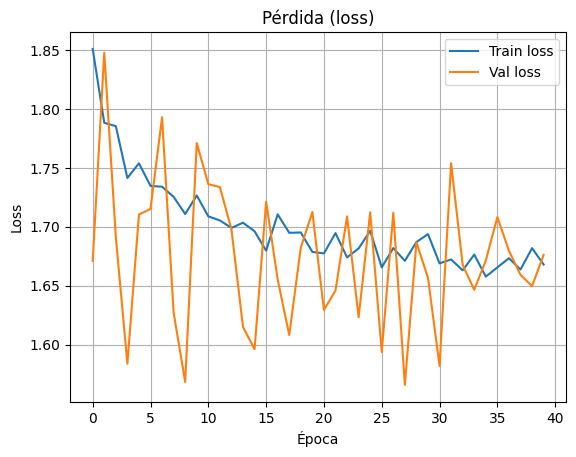

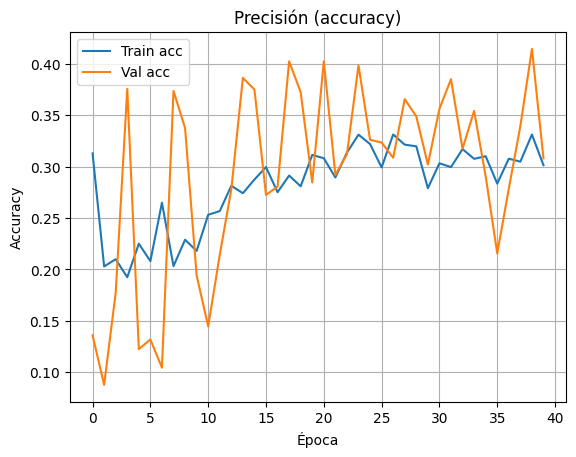

In [118]:
import matplotlib.pyplot as plt

# Curva de pérdida
plt.plot(history_tab_w.history['loss'], label='Train loss')
plt.plot(history_tab_w.history['val_loss'], label='Val loss')
plt.title('Pérdida (loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Curva de precisión
plt.plot(history_tab_w.history['accuracy'], label='Train acc')
plt.plot(history_tab_w.history['val_accuracy'], label='Val acc')
plt.title('Precisión (accuracy)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 800x600 with 0 Axes>

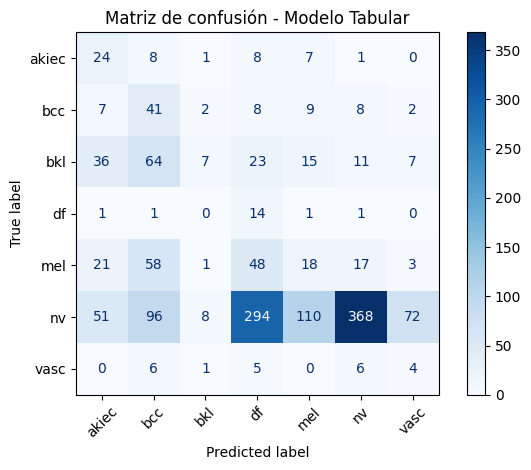

In [122]:
import numpy as np

# Si tus etiquetas están en one-hot
if len(y_test.shape) > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Etiquetas de texto
labels = le_dx.classes_  # Asegúrate de que le_dx sea tu LabelEncoder de 'dx'

# Crear matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Visualizar
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de confusión - Modelo Tabular")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Precisión total del modelo: {accuracy:.4f}")


🔍 Precisión total del modelo: 0.3186


In [130]:
from sklearn.metrics import classification_report

print(classification_report(y_test_labels, y_pred_labels, target_names=le_dx.classes_))


              precision    recall  f1-score   support

       akiec       0.17      0.49      0.25        49
         bcc       0.15      0.53      0.23        77
         bkl       0.35      0.04      0.08       163
          df       0.04      0.78      0.07        18
         mel       0.11      0.11      0.11       166
          nv       0.89      0.37      0.52       999
        vasc       0.05      0.18      0.07        22

    accuracy                           0.32      1494
   macro avg       0.25      0.36      0.19      1494
weighted avg       0.66      0.32      0.39      1494



In [124]:
nuevo_paciente = {
    'age': 70,
    'sex': 'male',
    'localization': 'ear'
}

In [125]:
# Codificar sexo y localización
sex_cod = le_sex.transform([nuevo_paciente['sex']])[0]
loc_cod = le_loc.transform([nuevo_paciente['localization']])[0]

# Crear array con los tres valores
X_nuevo = np.array([[nuevo_paciente['age'], sex_cod, loc_cod]])

# Escalar como antes
X_nuevo_scaled = scaler.transform(X_nuevo)

In [126]:
# Predecir
pred_probs = model_tab.predict(X_nuevo_scaled)
pred_clase = np.argmax(pred_probs)
clase_nombre = le_dx.inverse_transform([pred_clase])[0]

print("Diagnóstico predicho:", clase_nombre)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Diagnóstico predicho: bcc


# HITO 2

In [127]:
images = np.loadtxt('hnmist_28_28_RGB.csv', delimiter=',', skiprows=1)
num_images = images.shape[0]
images = images.reshape((num_images, 28, 28, 3))
images = images / 255.0

In [128]:
images_filter= images[df_tab.index]
print(images_filter.shape)

(9958, 28, 28, 3)


In [129]:
print("Imágenes:", images_filter.shape)
print("Etiquetas:", y_cat.shape)

Imágenes: (9958, 28, 28, 3)
Etiquetas: (9958, 7)


In [131]:
from sklearn.model_selection import train_test_split
import numpy as np

# Crear índices
indices = np.arange(len(images_filter))

# División train (70%) y temp (30%)
train_idx, temp_idx, _, y_temp = train_test_split(
    indices, y_cat, test_size=0.3, random_state=42, stratify=y_cat
)

# División de temp en val (15%) y test (15%)
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# División de imágenes y etiquetas
X_img_train = images_filter[train_idx]
X_img_val   = images_filter[val_idx]
X_img_test  = images_filter[test_idx]

y_train = y_cat[train_idx]
y_val   = y_cat[val_idx]
y_test  = y_cat[test_idx]

print("Train:", X_img_train.shape)
print("Val:  ", X_img_val.shape)
print("Test: ", X_img_test.shape)


Train: (6970, 28, 28, 3)
Val:   (1494, 28, 28, 3)
Test:  (1494, 28, 28, 3)


In [132]:
import tensorflow as tf

# Redimensionar imágenes a 96x96 (aceptado por MobileNetV2)
IMG_SIZE = 96
X_img_train_resized = tf.image.resize(X_img_train, (IMG_SIZE, IMG_SIZE))
X_img_val_resized   = tf.image.resize(X_img_val, (IMG_SIZE, IMG_SIZE))
X_img_test_resized  = tf.image.resize(X_img_test, (IMG_SIZE, IMG_SIZE))


In [157]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = np.argmax(y_train, axis=1)  # de one-hot a entero
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_labels),
                                     y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights_dict)  # para ver los pesos calculados


Pesos de clase: {0: np.float64(4.348097317529632), 1: np.float64(2.765873015873016), 2: np.float64(1.3067116610423697), 3: np.float64(12.446428571428571), 4: np.float64(1.279838413514506), 5: np.float64(0.21358092786664215), 6: np.float64(10.057720057720058)}


In [160]:
# Definimos el espacio de búsqueda para Hyperopt
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-3)),
    'dropout': hp.uniform('dropout', 0.3, 0.6),
    'dense_units': hp.choice('dense_units', [64, 128, 256]),
    'batch_size': hp.choice('batch_size', [16, 32, 64])
}

# Función objetivo
num_classes = y_train.shape[1]

def objective(params):
    base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(params['dropout'])(x)
    x = Dense(params['dense_units'], activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_img_train_resized, y_train,
        validation_data=(X_img_val_resized, y_val),
        epochs=15,
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )

    val_acc = history.history['val_accuracy'][-1]
    return {'loss': -val_acc, 'status': STATUS_OK}

# Ejecutar búsqueda
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

print("\n🔍 Mejor combinación de hiperparámetros:")
print(best)


  5%|▌         | 1/20 [07:13<2:17:13, 433.34s/trial, best loss: -0.6954484581947327]


KeyboardInterrupt: 

In [ ]:
best_dropout = best['dropout']
best_units = [64, 128, 256][best['dense_units']]
best_batch_size = [16, 32, 64][best['batch_size']]
best_lr = best['learning_rate']

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cargar base preentrenada sin la parte final
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet"
)

# Congelar pesos del modelo base
base_model.trainable = False

# Añadir capas propias (clasificador final)
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
outputs = Dense(y_train.shape[1], activation="softmax")(x)

model_tl = Model(inputs, outputs)

# Compilar
model_tl.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

# Entrenamiento
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_tl = model_tl.fit(
    # X_img_train_resized, y_train,
    datagen.flow(X_img_train_resized, y_train, batch_size=32),
    validation_data=(X_img_val_resized, y_val),
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/30


c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2539 - loss: 2.2036 - val_accuracy: 0.2738 - val_loss: 1.7343
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.3325 - loss: 1.6385 - val_accuracy: 0.4518 - val_loss: 1.4710
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step - accuracy: 0.3627 - loss: 1.5479 - val_accuracy: 0.3882 - val_loss: 1.4637
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.3959 - loss: 1.4921 - val_accuracy: 0.4659 - val_loss: 1.4053
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.3979 - loss: 1.4560 - val_accuracy: 0.5194 - val_loss: 1.3118
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.4493 - loss: 1.3451 - val_accuracy: 0.4371 - val_loss: 1.4136
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - accuracy: 0.4510 - loss: 1.3742 - val_accuracy: 0.5261 - val_loss: 1.2752
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.4617 - loss: 1.3803 - val

In [190]:
model_tl.summary()

Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_73 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,752,599 (10.50 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 329,744 (1.26 MB)

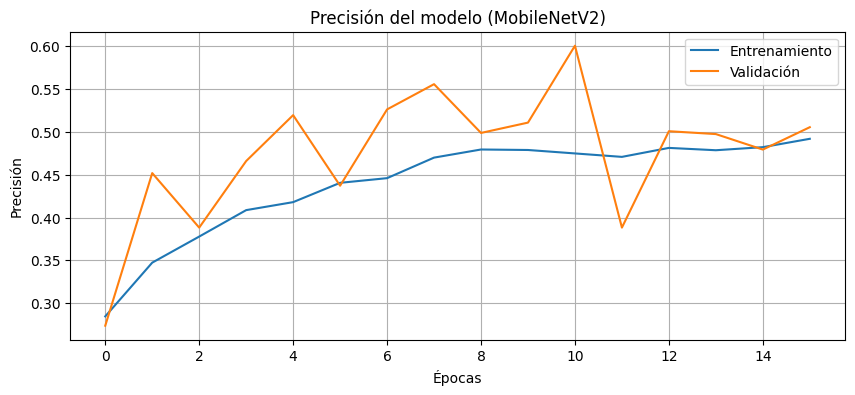

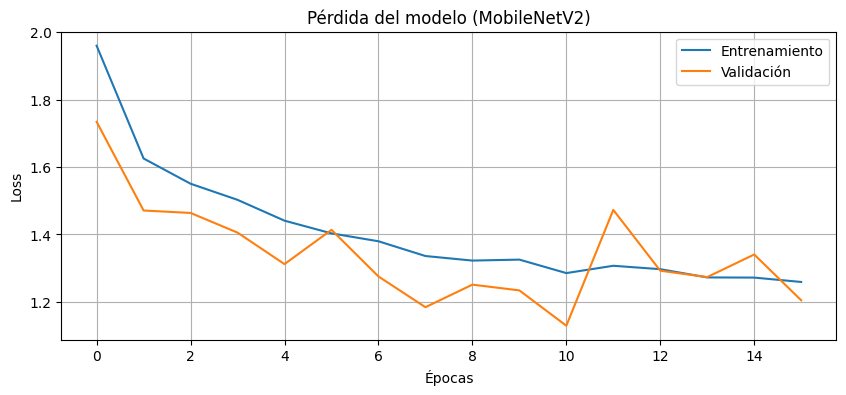

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history_tl.history['accuracy'], label='Entrenamiento')
plt.plot(history_tl.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo (MobileNetV2)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(history_tl.history['loss'], label='Entrenamiento')
plt.plot(history_tl.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo (MobileNetV2)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



📊 Classification Report:
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step
              precision    recall  f1-score   support

       akiec       0.17      0.53      0.26        49
         bcc       0.38      0.27      0.32        77
         bkl       0.29      0.37      0.33       163
          df       0.08      0.39      0.13        18
         mel       0.40      0.36      0.38       166
          nv       0.91      0.71      0.80       999
        vasc       0.22      0.73      0.34        22

    accuracy                           0.60      1494
   macro avg       0.35      0.48      0.37      1494
weighted avg       0.71      0.60      0.64      1494



<Figure size 800x600 with 0 Axes>

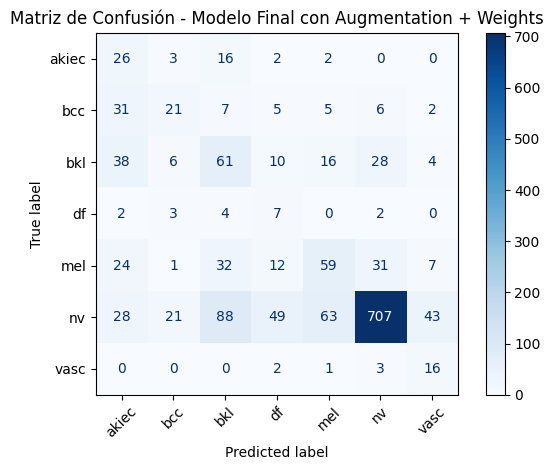

In [ ]:
# Evaluación final
print("\n📊 Classification Report:")
y_pred_probs = model_tl.predict(X_img_test_resized)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(classification_report(y_test_labels, y_pred_labels, target_names=le_dx.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_dx.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()


In [137]:
y_pred_probs = model_tl.predict(X_img_test_resized)
y_pred_labels = np.argmax(y_pred_probs, axis=1)


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


lesion_id        HAM_0005988
image_id        ISIC_0025646
dx                        nv
dx_type            follow_up
age                     35.0
sex                   female
localization           trunk
Name: 5512, dtype: object
(28, 28, 3)
[ 0.77418414 -1.08846929 -0.41065231]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


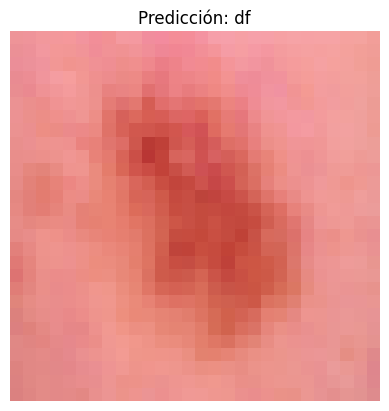

In [188]:
import numpy as np
import matplotlib.pyplot as plt

id = 5512
data_meta = metadata.iloc[id]
img = images_filter[id]

print(data_meta)
print(img.shape)

X_test[0].shape  # (96, 96, 3)
print(X_test[0])

# 2. Redimensionar como en el entrenamiento
img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
img_resized = np.expand_dims(img_resized, axis=0)  # → (1, 96, 96, 3)

# 3. Predecir
pred = model_tl.predict(img_resized)
pred_label = np.argmax(pred)
pred_class = le_dx.inverse_transform([pred_label])[0]

# 4. Mostrar resultado
plt.imshow(img)
plt.title(f"Predicción: {pred_class}")
plt.axis("off")
plt.show()

In [212]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_img = Input(shape=(96, 96, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.4)(x)  # ← nuevo dropout antes de Dense
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(y_cat.shape[1], activation='softmax')(x)

model_img = Model(inputs=input_img, outputs=output)
model_img.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])


In [213]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [214]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


In [215]:
history_img = model_img.fit(
    datagen.flow(X_img_train_resized, y_train, batch_size=32),
    validation_data=(X_img_val_resized, y_val),
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30


c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 65s 290ms/step - accuracy: 0.5953 - loss: 1.5227 - val_accuracy: 0.2323 - val_loss: 1.7933
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 65s 297ms/step - accuracy: 0.6681 - loss: 0.9640 - val_accuracy: 0.6801 - val_loss: 0.9392
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 68s 311ms/step - accuracy: 0.6652 - loss: 0.9632 - val_accuracy: 0.6774 - val_loss: 0.8940
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 60s 276ms/step - accuracy: 0.6857 - loss: 0.8950 - val_accuracy: 0.6687 - val_loss: 1.2512
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 60s 275ms/step - accuracy: 0.6784 - loss: 0.9056 - val_accuracy: 0.6888 - val_loss: 0.8585
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 72s 332ms/step - accuracy: 0.6882 - loss: 0.8798 - val_accuracy: 0.6727 - val_loss: 1.0189
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 74s 341ms/step - accuracy: 0.6826 - loss: 0.8780 - val_accuracy: 0.6780 - val_loss: 0.9426
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 75s 344ms/step - accuracy: 0.6866 - loss: 0.8330 - val

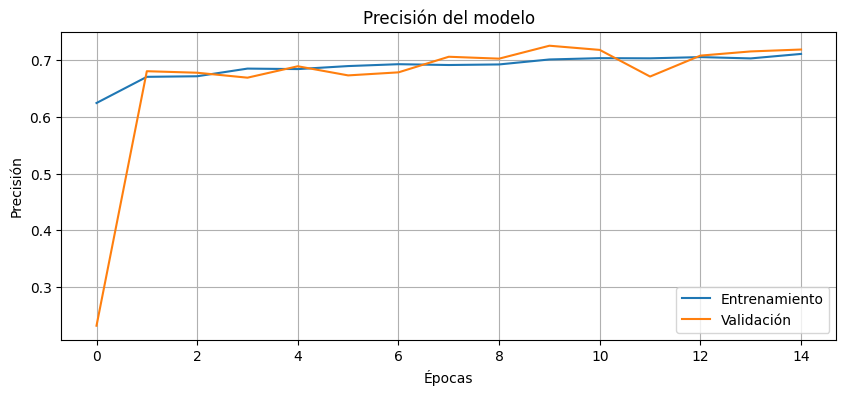

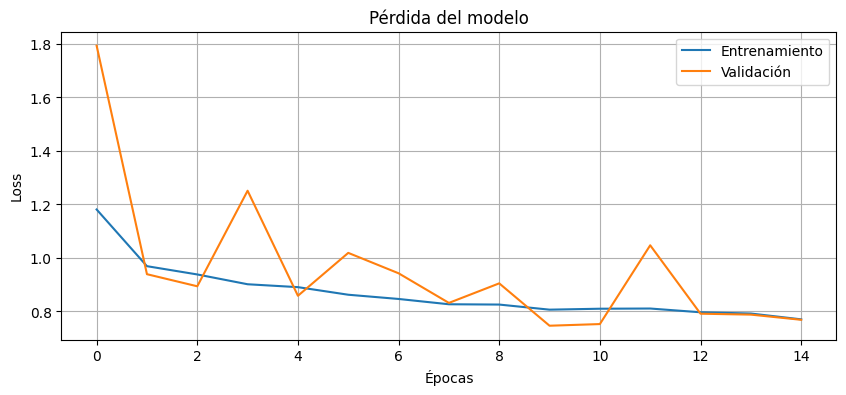

In [216]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history_img.history['accuracy'], label='Entrenamiento')
plt.plot(history_img.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(history_img.history['loss'], label='Entrenamiento')
plt.plot(history_img.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



📊 Classification Report:
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        49
         bcc       0.43      0.52      0.47        77
         bkl       0.41      0.44      0.42       163
          df       0.00      0.00      0.00        18
         mel       0.73      0.10      0.17       166
          nv       0.79      0.94      0.86       999
        vasc       0.89      0.36      0.52        22

    accuracy                           0.72      1494
   macro avg       0.46      0.34      0.35      1494
weighted avg       0.69      0.72      0.67      1494



c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defi

<Figure size 800x600 with 0 Axes>

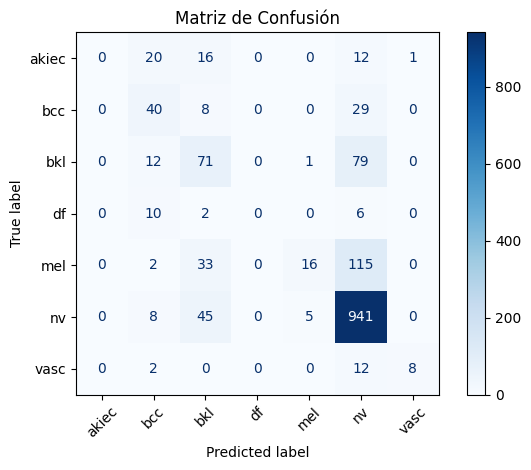

In [217]:
# Evaluación final
print("\n📊 Classification Report:")
y_pred_probs = model_img.predict(X_img_test_resized)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(classification_report(y_test_labels, y_pred_labels, target_names=le_dx.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_dx.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()


lesion_id        HAM_0004105
image_id        ISIC_0030007
dx                       bkl
dx_type                histo
age                     85.0
sex                   female
localization            hand
Name: 444, dtype: object
(28, 28, 3)
[ 0.77418414 -1.08846929 -0.41065231]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


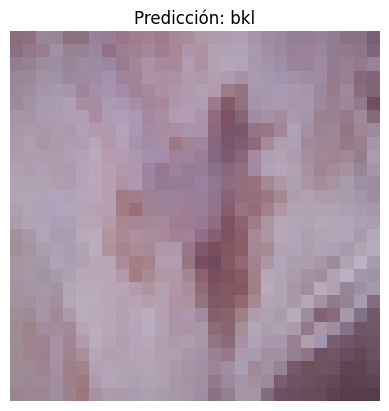

In [218]:
import numpy as np
import matplotlib.pyplot as plt

id = 444
data_meta = metadata.iloc[id]
img = images_filter[id]

print(data_meta)
print(img.shape)

X_test[0].shape  # (96, 96, 3)
print(X_test[0])

# 2. Redimensionar como en el entrenamiento
img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
img_resized = np.expand_dims(img_resized, axis=0)  # → (1, 96, 96, 3)

# 3. Predecir
pred = model_img.predict(img_resized)
pred_label = np.argmax(pred)
pred_class = le_dx.inverse_transform([pred_label])[0]

# 4. Mostrar resultado
plt.imshow(img)
plt.title(f"Predicción: {pred_class}")
plt.axis("off")
plt.show()

# HITO 3

In [221]:
X_img_train_resized.shape[0] == X_tab_train.shape[0] == y_train.shape[0]


False

In [223]:
print("X_img_train_resized:", X_img_train_resized.shape)
print("X_tab_train:", X_train.shape)
print("y_train:", y_train.shape)


X_img_train_resized: (6970, 96, 96, 3)
X_tab_train: (6970, 3)
y_train: (6970, 7)


In [224]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

# Entrada de imagen
input_img = Input(shape=(96, 96, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Entrada tabular
input_tab = Input(shape=(X_train.shape[1],))
y = Dense(64, activation='relu')(input_tab)
y = Dropout(0.3)(y)
y = Dense(32, activation='relu')(y)

# Fusión
combined = Concatenate()([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(y_cat.shape[1], activation='softmax')(z)

# Modelo final
model_combined = Model(inputs=[input_img, input_tab], outputs=output)
model_combined.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [225]:
history_combined = model_combined.fit(
    [X_img_train_resized, X_train],
    y_train,
    validation_data=([X_img_val_resized, X_val], y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.6418 - loss: 1.1864 - val_accuracy: 0.7108 - val_loss: 0.8418
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 27s 124ms/step - accuracy: 0.6935 - loss: 0.8949 - val_accuracy: 0.7256 - val_loss: 0.7884
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - accuracy: 0.7043 - loss: 0.8188 - val_accuracy: 0.7316 - val_loss: 0.7556
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - accuracy: 0.7205 - loss: 0.7814 - val_accuracy: 0.7363 - val_loss: 0.7207
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - accuracy: 0.7289 - loss: 0.7352 - val_accuracy: 0.7336 - val_loss: 0.6954
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 26s 121ms/step - accuracy: 0.7348 - loss: 0.7070 - val_accuracy: 0.7463 - val_loss: 0.6861
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - accuracy: 0.7459 - loss: 0.6798 - val_accuracy: 0.7376 - val_loss: 0.6833
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - accuracy: 0.7539 - loss: 0

In [226]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

# Predicción en test
y_pred_probs = model_combined.predict([X_img_test_resized, X_test])
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Accuracy
acc_combined = accuracy_score(y_true_labels, y_pred_labels)
print(f"\n✅ Accuracy en test (modelo combinado): {acc_combined:.4f}")

# F1 macro
f1_macro_combined = f1_score(y_true_labels, y_pred_labels, average='macro')
print(f"✅ F1 macro en test (modelo combinado): {f1_macro_combined:.4f}")

# Reporte completo
print("\n📊 Classification Report (modelo combinado):")
print(classification_report(y_true_labels, y_pred_labels, target_names=le_dx.classes_))


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step

✅ Accuracy en test (modelo combinado): 0.7637
✅ F1 macro en test (modelo combinado): 0.4698

📊 Classification Report (modelo combinado):
              precision    recall  f1-score   support

       akiec       0.42      0.22      0.29        49
         bcc       0.55      0.48      0.51        77
         bkl       0.47      0.49      0.48       163
          df       0.11      0.06      0.07        18
         mel       0.60      0.31      0.41       166
          nv       0.84      0.95      0.89       999
        vasc       1.00      0.45      0.62        22

    accuracy                           0.76      1494
   macro avg       0.57      0.42      0.47      1494
weighted avg       0.74      0.76      0.74      1494



lesion_id        HAM_0001487
image_id        ISIC_0031601
dx                       bkl
dx_type            consensus
age                     60.0
sex                     male
localization            neck
Name: 976, dtype: object
(28, 28, 3)
[ 0.77418414 -1.08846929 -0.41065231]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicción: bkl


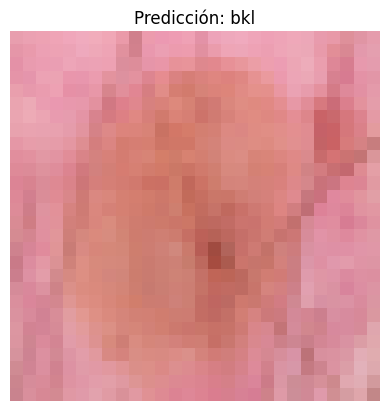

In [239]:
import numpy as np
import matplotlib.pyplot as plt

id = 976
data_meta = metadata.iloc[id]
img = images_filter[id]

print(data_meta)
print(img.shape)

X_test[0].shape  # (96, 96, 3)
print(X_test[0])

# 2. Redimensionar como en el entrenamiento
img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
img_resized = np.expand_dims(img_resized, axis=0)  # → (1, 96, 96, 3)

nuevo_paciente = {
    'age': 70,
    'sex': 'male',
    'localization': 'ear'
}
# Codificar sexo y localización
sex_cod = le_sex.transform([nuevo_paciente['sex']])[0]
loc_cod = le_loc.transform([nuevo_paciente['localization']])[0]

# Crear array con los tres valores
X_nuevo = np.array([[nuevo_paciente['age'], sex_cod, loc_cod]])

# Escalar como antes
X_nuevo_scaled = scaler.transform(X_nuevo)

# Ejemplo con una imagen + datos tabulares
pred = model_combined.predict([[img_resized], [X_nuevo_scaled]])
clase = le_dx.inverse_transform([np.argmax(pred)])
print("Predicción:", clase[0])

# 4. Mostrar resultado
plt.imshow(img)
plt.title(f"Predicción: {clase[0]}")
plt.axis("off")
plt.show()

# HITO 4

In [240]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Entradas
input_img = Input(shape=(96, 96, 3))
input_tab = Input(shape=(X_train.shape[1],))

# 2. Aplanamos la imagen directamente (sin convoluciones)
flat_img = Flatten()(input_img)

# 3. Concatenamos imagen + datos tabulares → EARLY FUSION
merged = Concatenate()([flat_img, input_tab])

# 4. Capas densas después de la fusión
x = Dense(256, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(y_cat.shape[1], activation='softmax')(x)

# 5. Modelo
model_early = Model(inputs=[input_img, input_tab], outputs=output)
model_early.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Entrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_early = model_early.fit(
    [X_img_train_resized, X_train],
    y_train,
    validation_data=([X_img_val_resized, X_val], y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.5710 - loss: 2.5131 - val_accuracy: 0.6432 - val_loss: 1.3331
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.6561 - loss: 1.1622 - val_accuracy: 0.6687 - val_loss: 1.0056
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.6671 - loss: 1.0540 - val_accuracy: 0.6687 - val_loss: 1.1511
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.6684 - loss: 1.0978 - val_accuracy: 0.6687 - val_loss: 1.0061
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.6669 - loss: 1.0809 - val_accuracy: 0.6687 - val_loss: 0.9999
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.6630 - loss: 1.0622 - val_accuracy: 0.6687 - val_loss: 0.9974
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.6669 - loss: 1.0771 - val_accuracy: 0.6687 - val_loss: 1.0019
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.6551 - loss: 1.0872 - 

In [241]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

# Predicción en test
y_pred_probs_early = model_early.predict([X_img_test_resized, X_test])
y_pred_labels_early = np.argmax(y_pred_probs_early, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Accuracy
acc_early = accuracy_score(y_true_labels, y_pred_labels_early)
print(f"\n✅ Accuracy en test (Early Fusion): {acc_early:.4f}")

# F1 macro
f1_macro_early = f1_score(y_true_labels, y_pred_labels_early, average='macro')
print(f"✅ F1 macro en test (Early Fusion): {f1_macro_early:.4f}")

# Reporte completo
print("\n📊 Classification Report (Early Fusion):")
print(classification_report(y_true_labels, y_pred_labels_early, target_names=le_dx.classes_))


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

✅ Accuracy en test (Early Fusion): 0.6687
✅ F1 macro en test (Early Fusion): 0.1145

📊 Classification Report (Early Fusion):
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        49
         bcc       0.00      0.00      0.00        77
         bkl       0.00      0.00      0.00       163
          df       0.00      0.00      0.00        18
         mel       0.00      0.00      0.00       166
          nv       0.67      1.00      0.80       999
        vasc       0.00      0.00      0.00        22

    accuracy                           0.67      1494
   macro avg       0.10      0.14      0.11      1494
weighted avg       0.45      0.67      0.54      1494



c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defi